# **DataKit Challenge: Producers Direct**

## **Challenge 2: Seasonality (Kenya)** 
## **Part II (Temporal Word Analysis)**

By Conrad Kleykamp

Table of Contents:
- [Executive Summary](#1)
- [Set Up](#2)
- [Natural Language Processing](#3)
    - [Tokenization & Removing Stopwords](#3.1)
    - [Temporal Word Counts](#3.2)
    - [Identifying Most Frequent Words](#3.3)
- [Visualizations](#4)

## **1) Executive Summary**

---

### **Overview**

Relevant Challenge:

- **Challenge 2: Seasonality**

The overarching goal of this project is to identify seasonal patterns (based on temporal data) that may influence the types of questions that farmers ask. Predictive insights may assist farmers by preemptively determining their needs prior to significant weather/climate/seasonal challenges. 

### **Current Project Phase: Temporal Word Frequency Analysis (Kenya)**

In my first submission, I identified Kenya as a suitable candidate for seasonal analysis, as it had a large volume of English questions and had a significant temporal range, i.e. 9.76M questions, 77% English, 4.6 years (2017-2022).

In my second submission, I created and stored a new dataframe that was filtered to include only questions from Kenya that were in English. This dataframe was then used to analyze question volume across different temporal categories, i.e. Kenya agricultural season, standard meteorological season, and month. 

In this current phase, the top 20 most frequent words (by temporal category) per 1000 questions were extracted from the dataframe generated in phase 2. Following this, the top 15 most frequent words were visualized in a stack of heatmaps.

### **Methodology**

- **Natural Language Processing**:
    - Extracted words from 7.5M English language questions using regex tokenization (3+ character alphabetic words, lowercase).
    - Applied NLTK stopwords plus custom agricultural-specific terms to filter 223 common words.
- **Word Frequency Calculation**:
    -  Built frequency distributions for three temporal groupings using Counter objects
- **Top Word Identification**:
    - Extracted top 20 words per temporal period, filtering words appearing more than 75 times.
    - Calculated two metrics per word: (1) frequency per 1,000 questions for normalized comparison, and (2) percentage of total filtered words for relative importance within each period.
- **Visualization**:
    - Generated a three-panel stacked heatmap showing the top 15 most frequent words (per 1000 questions) across all temporal groups.
    - Applied RdYlGn_r color palette for optimal contrast across frequency ranges.   

### **Key Findings**

- **Dominant Agricultural Terms**:
    - Core agricultural vocabulary remains consistent across all temporal groupings.
    - "plant" and "maize" consistently constitute the top 2 words across all temporal periods.
    - Both terms exhibit their highest frequencies during the Transition agricultural season ("plant": 183.3, "maize": 216.4).
- **Ranking of Agricultural/Animal Products**:
    - The most common agricultural/animal products had the following ranking in terms of highest to lowest frequencies (by Kenya agricultural season:
    - maize, cow, beans, tomatoes, chicken, potatoes, dairy, chicks  
- **Maize**:
    - "maize" exhibits its highest frequencies during September (216.4) and October (284.7).
    - This suggests that farmers may be preparing for/planting maize most frequently during the transition period (September) into the beginning of the short rains/secondary planting season (October).
    - "maize" frequency is consistently high (>105.0) across all agricultural seasons, suggesting that the crop is planted and harvested multiple times per year. 

- **Cow**:
    - Overall, "cow" is the third most frequent word.
    - "cow" frequency is the highest in December (143.1) and subsequently in the short rains/secondary planting season (102.1).
- **Other Notable Relationships**:
    - "cow" and "dairy" share the same increases in frequencies, suggesting that farmers are either preparing to sell or produce dairy during December/short rains season.
    - "tomatoes" exhibits a singular upward spike in frequency during August (96.1), suggesting that farmers are harvesting this crop during the end of Harvest 1. 

### **Next Steps**

- **Latent Dirichlet Allocation (LDA) topic modeling** to identify hidden thematic patterns beyond single-word frequencies and discover semantic relationships between agricultural concepts 

## **2) Set Up**

---

In [1]:
# Loading in necessary libraries and packages

# Fundamental libraries
import numpy as np 
import pandas as pd 
from collections import Counter

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'Set2')
pal = sns.color_palette('Set2')

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Regex
import re

# NLTK
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

In [8]:
# Loading in the data (parquet, cleaned from last notebook)
print("Loading data...")
df = pd.read_parquet('/kaggle/input/kenya-english-questions/kenya_english_questions_cleaned.parquet')
print(f"Loaded {len(df):,} rows\n")

Loading data...
Loaded 7,511,473 rows



## **3) Natural Language Processing**

---

### **3.1) Tokenization & Removing Stopwords**

In [17]:
def extract_words(text):
    """
    Extracting meaningful words from text
    - Lowercase
    - 3+ characters
    - Alphabetic only
    """
    if pd.isna(text):
        return []
    words = re.findall(r'\b[a-z]{3,}\b', text.lower())
    return words

# Getting NLTK stop words
print("\nLoading stop words from NLTK...")
stop_words = set(stopwords.words('english'))

# Adding custom agricultural/platform-specific terms
custom_stop_words = {
    'one', 'two', 'three', 'may', 'well', 'says', 'said', 'say', 
    'asked', 'asks', 'ask', 'reply', 'response', 'followed', 'follow',
    'get', 'type', 'use', 'many', 'give', 'want', 'long', 'best', 'good',
    'take'
}
stop_words.update(custom_stop_words)

print(f"Total stop words: {len(stop_words)} (NLTK + custom)")

# Extracting words from all questions
print("\nExtracting words from questions...")
df['words'] = df['question_content'].apply(extract_words)
print("Word extraction complete")


Loading stop words from NLTK...
Total stop words: 223 (NLTK + custom)

Extracting words from questions...
Word extraction complete


### **3.2) Temporal Word Counts**

In [18]:
# Building word frequencies by temporal grouping

def build_temporal_freq(df, grouping_column):
    """
    Efficiently build word frequency by any temporal grouping
    
    Parameters:
    - df: dataframe with 'words' column
    - grouping_column: column name for temporal grouping
    
    Returns:
    - dict: {group_value: Counter object}
    """
    freq_dict = {}
    
    for group_value in sorted(df[grouping_column].unique()):
        group_mask = df[grouping_column] == group_value
        # Flattening all words for this group
        all_words = [word for words_list in df.loc[group_mask, 'words'] for word in words_list]
        freq_dict[group_value] = Counter(all_words)
    
    return freq_dict

# Building frequency dictionaries
print("\nProcessing Kenya agricultural seasons...")
kenya_season_freq = build_temporal_freq(df, 'kenya_season')
for season, counter in kenya_season_freq.items():
    print(f"  {season:30s}: {sum(counter.values()):,} total words")

print("\nProcessing standard meteorological seasons...")
standard_season_freq = build_temporal_freq(df, 'standard_season')
for season, counter in standard_season_freq.items():
    print(f"  {season:10s}: {sum(counter.values()):,} total words")

print("\nProcessing months...")
month_freq = build_temporal_freq(df, 'month')
for month, counter in month_freq.items():
    month_name = df[df['month'] == month]['month_name'].iloc[0]
    print(f"  {month:2d} ({month_name:9s}): {sum(counter.values()):,} total words")


Processing Kenya agricultural seasons...
  Harvest 1 (Jun-Aug)           : 15,496,393 total words
  Harvest 2 (Jan-Feb)           : 5,839,311 total words
  Long Rains (Mar-May)          : 14,386,908 total words
  Short Rains (Oct-Dec)         : 21,106,833 total words
  Transition (Sep)              : 7,147,479 total words

Processing standard meteorological seasons...
  Fall      : 14,386,908 total words
  Spring    : 21,174,838 total words
  Summer    : 12,918,785 total words
  Winter    : 15,496,393 total words

Processing months...
   1 (January  ): 3,040,349 total words
   2 (February ): 2,798,962 total words
   3 (March    ): 3,875,945 total words
   4 (April    ): 5,397,115 total words
   5 (May      ): 5,113,848 total words
   6 (June     ): 3,888,462 total words
   7 (July     ): 3,622,424 total words
   8 (August   ): 7,985,507 total words
   9 (September): 7,147,479 total words
  10 (October  ): 6,046,957 total words
  11 (November ): 7,980,402 total words
  12 (December ): 

### **3.3) Identifying Most Frequent Words**

In [22]:
# Extracting top 20 most frequent words

# Adaptive threshold based on dataset size
min_count = max(20, len(df) // 100000)
print(f"\nUsing minimum word count threshold: {min_count}")

def get_top_words(freq_dict, df, grouping_column, stop_words, top_n=50, min_count=20):
    """
    Extract top N words for each group in a temporal grouping
    
    Parameters:
    - freq_dict: Counter dict from build_temporal_freq
    - df: dataframe
    - grouping_column: column name for grouping
    - stop_words: set of stop words to exclude
    - top_n: number of top words to return
    - min_count: minimum word frequency threshold
    
    Returns:
    - dict: {group_value: list of word data dicts}
    """
    top_words_dict = {}
    
    for group_value, word_count in freq_dict.items():
        n_questions = (df[grouping_column] == group_value).sum()
        
        # Filtering stop words and low-frequency words
        filtered = {
            word: count for word, count in word_count.items()
            if word not in stop_words and count >= min_count
        }
        
        # Getting top N
        top_words = sorted(filtered.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        # Calculating total filtered word count for percentage
        total_filtered_words = sum(filtered.values())
        
        # Formatting output
        top_words_dict[group_value] = [
            {
                'word': word,
                'count': count,
                'per_1000_questions': (count / n_questions * 1000) if n_questions > 0 else 0,
                'percentage': (count / total_filtered_words * 100) if total_filtered_words > 0 else 0
            }
            for word, count in top_words
        ]
    
    return top_words_dict

# Extracting top 20 words for each temporal grouping
print("\nKENYA AGRICULTURAL SEASONS:")
print("-" * 60)
kenya_season_top_words = get_top_words(kenya_season_freq, df, 'kenya_season', 
                                       stop_words, top_n=20, min_count=min_count)
standard_season_top_words = get_top_words(standard_season_freq, df, 'standard_season', 
                                          stop_words, top_n=20, min_count=min_count)
month_top_words = get_top_words(month_freq, df, 'month', 
                                stop_words, top_n=20, min_count=min_count)

# Printing out temporal word frequency for Kenya agricultural season
for season in sorted(kenya_season_top_words.keys()):
    print(f"\n{season}:")
    print(f"  Top 20 words:")
    for i, word_data in enumerate(kenya_season_top_words[season][:20], 1):
        print(f"  {i:2d}. {word_data['word']:15s}: {word_data['per_1000_questions']:6.1f} per 1K -- {word_data['percentage']:5.1f}%")


Using minimum word count threshold: 75

KENYA AGRICULTURAL SEASONS:
------------------------------------------------------------

Harvest 1 (Jun-Aug):
  Top 20 words:
   1. plant          :  166.7 per 1K --   3.4%
   2. maize          :  105.0 per 1K --   2.2%
   3. cow            :   79.7 per 1K --   1.6%
   4. tomatoes       :   66.0 per 1K --   1.4%
   5. beans          :   48.3 per 1K --   1.0%
   6. crop           :   42.3 per 1K --   0.9%
   7. tomato         :   39.1 per 1K --   0.8%
   8. farm           :   34.3 per 1K --   0.7%
   9. planting       :   34.2 per 1K --   0.7%
  10. potatoes       :   33.8 per 1K --   0.7%
  11. season         :   30.9 per 1K --   0.6%
  12. control        :   28.8 per 1K --   0.6%
  13. chicken        :   27.1 per 1K --   0.6%
  14. county         :   26.4 per 1K --   0.5%
  15. dairy          :   26.2 per 1K --   0.5%
  16. chicks         :   26.2 per 1K --   0.5%
  17. crops          :   25.6 per 1K --   0.5%
  18. milk           :   25.2 per

## **4) Visualizations**

---


Creating stacked heatmap visualization...
Saved: temporal_word_frequency_stack.png


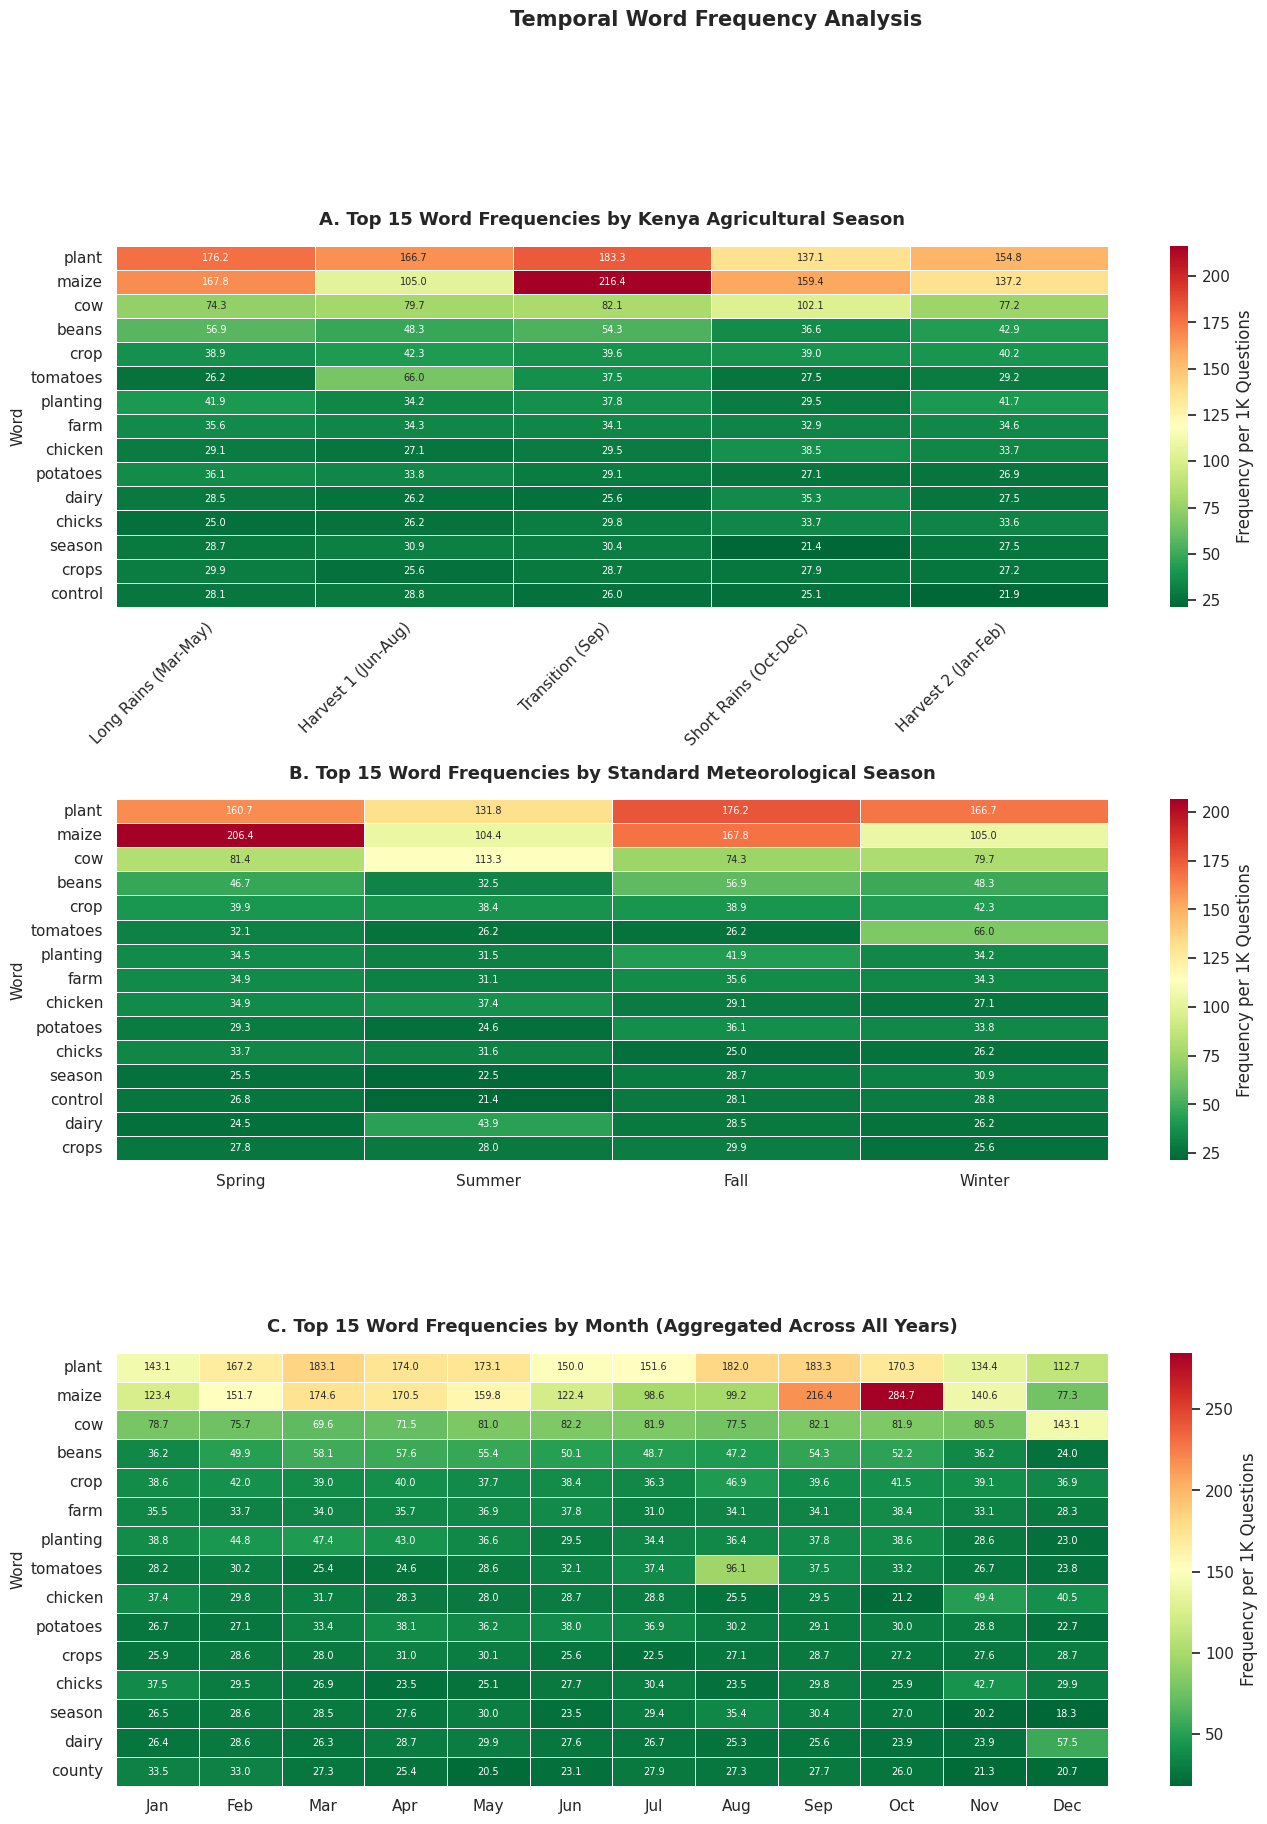

In [23]:
# Creating visualizations (heatmaps) for word frequencies across different temporal categories

def create_temporal_heatmap(ax, freq_dict, top_words_dict, df, 
                           grouping_column, group_order, title, 
                           x_labels=None, rotate_labels=False):
    """
    Create heatmap for temporal word frequencies
    
    Parameters:
    - ax: matplotlib axis
    - freq_dict: frequency Counter dict
    - top_words_dict: top words dict from get_top_words
    - df: dataframe
    - grouping_column: column name
    - group_order: list of groups in desired order
    - title: plot title
    - x_labels: optional custom x-axis labels
    - rotate_labels: whether to rotate x-axis labels
    
    Returns:
    - ax: modified matplotlib axis
    """
    # Getting overall top 15 words
    all_words = Counter()
    for group in group_order:
        if group in top_words_dict:
            for word_data in top_words_dict[group][:15]:
                all_words[word_data['word']] += word_data['count']
    
    top_15 = [word for word, count in all_words.most_common(15)]
    
    # Building matrix
    matrix = []
    for word in top_15:
        word_row = {'word': word}
        for group in group_order:
            count = freq_dict[group].get(word, 0)
            n_questions = (df[grouping_column] == group).sum()
            rate = (count / n_questions * 1000) if n_questions > 0 else 0
            word_row[group] = rate
        matrix.append(word_row)
    
    heatmap_df = pd.DataFrame(matrix).set_index('word')
    
    # Applying custom labels if provided
    if x_labels:
        heatmap_df.columns = x_labels
    
    # Creating heatmap
    sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                cbar_kws={'label': 'Frequency per 1K Questions'},
                linewidths=0.5, ax=ax, annot_kws={'fontsize': 7})
    ax.set_ylabel('Word', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
    
    if rotate_labels:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    return ax

print("\nCreating stacked heatmap visualization...")

# Creating figure
fig = plt.figure(figsize=(16, 20))
gs = fig.add_gridspec(3, 1, hspace=0.5, height_ratios=[1, 1, 1.2])

# Heatmap 1: Kenya Agricultural Seasons
kenya_season_order = ['Long Rains (Mar-May)', 'Harvest 1 (Jun-Aug)', 'Transition (Sep)', 
                      'Short Rains (Oct-Dec)', 'Harvest 2 (Jan-Feb)']
ax1 = fig.add_subplot(gs[0])
create_temporal_heatmap(ax1, kenya_season_freq, kenya_season_top_words, df,
                       'kenya_season', kenya_season_order,
                       'A. Top 15 Word Frequencies by Kenya Agricultural Season',
                       rotate_labels=True)

# Heatmap 2: Standard Meteorological Seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
ax2 = fig.add_subplot(gs[1])
create_temporal_heatmap(ax2, standard_season_freq, standard_season_top_words, df,
                       'standard_season', season_order,
                       'B. Top 15 Word Frequencies by Standard Meteorological Season')

# Heatmap 3: Months
month_order = list(range(1, 13))
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax3 = fig.add_subplot(gs[2])
create_temporal_heatmap(ax3, month_freq, month_top_words, df,
                       'month', month_order,
                       'C. Top 15 Word Frequencies by Month (Aggregated Across All Years)',
                       x_labels=month_labels)

# Finalizing figure
plt.tight_layout()
plt.suptitle('Temporal Word Frequency Analysis', fontsize=15, fontweight='bold', y=0.998)
plt.savefig('temporal_word_frequency_stack.png', dpi=300, bbox_inches='tight')
print("Saved: temporal_word_frequency_stack.png")
plt.show()
